<font face="Helvetica" size=7 color=#3c734d> **NLP Analysis of Disaster Tweets** </font><br>
Notebook Authored by: Katie McQuinn</br>
<font face="Helvetica" size=5 color=#3c734d> **Background** </font><br>
This project tackles a natural language processing (NLP) classification problem: identifying whether a tweet is about a real disaster or not. The dataset is drawn from tweets labeled either as <b>disaster-related</b> (target = 1) or <b>non-disaster</b> (target = 0).<br>
<font face="Helvetica" size=4 color=#3c734d> Import Packages </font></br>

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.initializers import Constant
from tensorflow.keras.callbacks import EarlyStopping

<font face="Helvetica" size=4 color=#3c734d> Read in Kaggle Data </font></br>

In [2]:
train_df = pd.read_csv("/content/drive/MyDrive/Data_Science/Disaster Tweets Project/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Data_Science/Disaster Tweets Project/test.csv")
submission_df = pd.read_csv("/content/drive/MyDrive/Data_Science/Disaster Tweets Project/sample_submission.csv")

<font face="Helvetica" size=5 color=#3c734d> **Exploratory Data Analysis** </font><br>

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
submission_df.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [7]:
# Get basic info for each dataset to help describe the structure
train_info = train_df.info()
test_info = test_df.info()
sample_submission_info = submission_df.info()

# Get descriptive statistics and missing value summary
train_description = train_df.describe(include='all')
test_description = test_df.describe(include='all')
train_missing = train_df.isnull().sum()
test_missing = test_df.isnull().sum()

(train_description, train_missing, test_description, test_missing)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   id      3

(                  id     keyword location  \
 count    7613.000000        7552     5080   
 unique           NaN         221     3341   
 top              NaN  fatalities      USA   
 freq             NaN          45      104   
 mean     5441.934848         NaN      NaN   
 std      3137.116090         NaN      NaN   
 min         1.000000         NaN      NaN   
 25%      2734.000000         NaN      NaN   
 50%      5408.000000         NaN      NaN   
 75%      8146.000000         NaN      NaN   
 max     10873.000000         NaN      NaN   
 
                                                      text      target  
 count                                                7613  7613.00000  
 unique                                               7503         NaN  
 top     11-Year-Old Boy Charged With Manslaughter of T...         NaN  
 freq                                                   10         NaN  
 mean                                                  NaN     0.42966  
 std    

<font face="Helvetica">
As is shown above, the data has 5 features. <br>

<u> Training Dataset Summary</u></font>

| Column Name | Description | Details|
|-------------|-------------|--------|
| ID | unique identifier | |
| keyword | disaster-related term |61 missing values|
| location | tweet location | 2533 missing values|
| text | tweet body | main feature |
| target | labels | 1: disaster, 0: non-disaster|

In [8]:
# checking dataset balance
train_df['target'].value_counts(normalize=True)

,proportion
target,
0,0.57034
1,0.42966


<font face="Helvetica">
This is a relatively balanced dataset with ~43% of tweets being classified as disaster tweets.

<br>
<font size=4 color=#3c734d> Pre-process Text Data </font></br>

I will start out cleaning the text by removing URLs, mentions & hashtags, and punctuation. If this model seems to not be performing well, I could go further by removing stopwords and using lemmatization. For our purposes though, I will continue with the following cleaning:

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # remove URLs
    text = re.sub(r'\@w+|\#','', text)  # remove mentions and hashtags
    text = re.sub(r'[^A-Za-z0-9\s]', '', text)  # remove punctuation
    return text

train_df["clean_text"] = train_df["text"].apply(clean_text)

In [10]:
train_df.head()

,id,keyword,location,text,target,clean_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby alaska as s...


<font face="Helvetica" size=4 color=#3c734d> Visualizing the Data </font></br>

The function below will show a histogram of the tweet lengths by class (disaster (1) vs non-disaster (0))

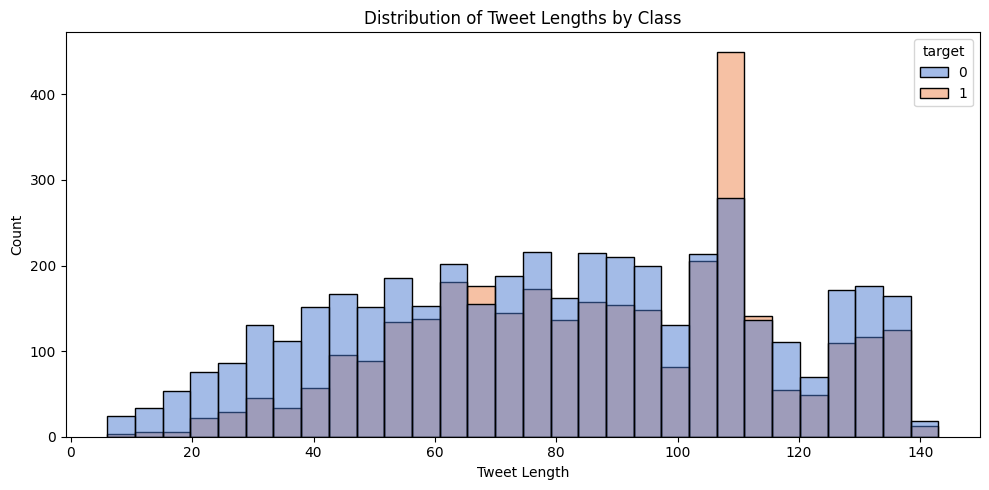

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histogram of tweet lengths
train_df["text_len"] = train_df["clean_text"].apply(len)
plt.figure(figsize=(10, 5))
sns.histplot(data=train_df, x="text_len", hue="target", bins=30, kde=False, palette="muted")
plt.title("Distribution of Tweet Lengths by Class")
plt.xlabel("Tweet Length")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

<font face ="Helvetica"> This histogram shows that most tweets fall between 50-110 characters, with disaster-related tweets (label 1) tending slightly longer than non-disaster tweets.

Next, let's generate a word could to get an intuitive sense of frequent words in each class.

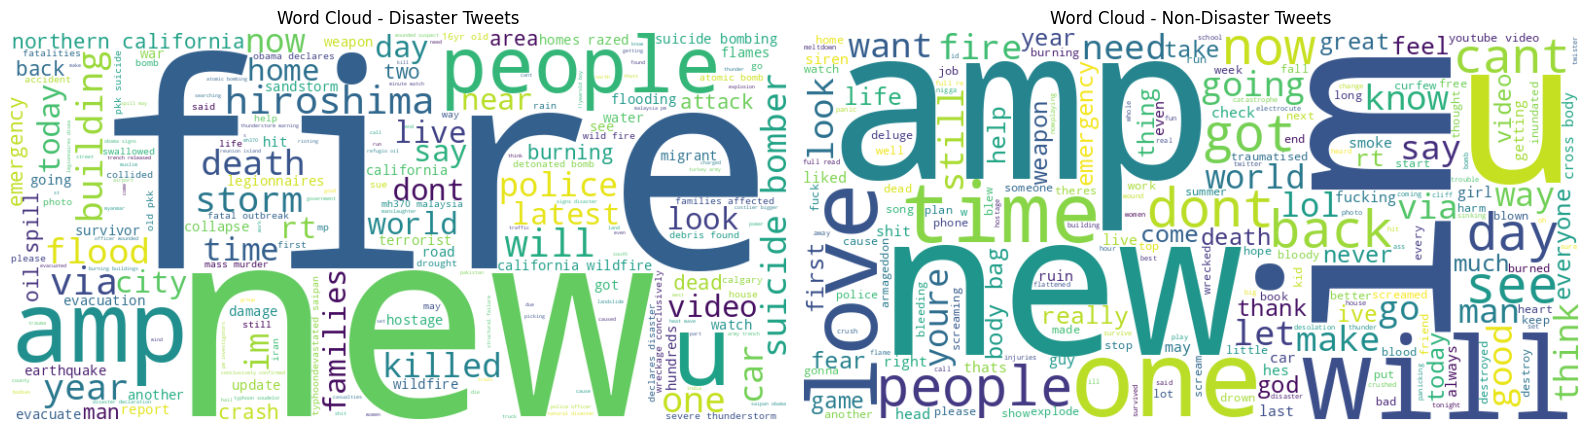

In [15]:
from wordcloud import WordCloud

# Separate disaster vs. non-disaster tweets
disaster_tweets = train_df[train_df["target"] == 1]["clean_text"]
nondisaster_tweets = train_df[train_df["target"] == 0]["clean_text"]

# Generate word clouds
disaster_wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(disaster_tweets))
nondisaster_wc = WordCloud(width=800, height=400, background_color="white").generate(" ".join(nondisaster_tweets))

# Plot both
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(disaster_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Disaster Tweets")

plt.subplot(1, 2, 2)
plt.imshow(nondisaster_wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Non-Disaster Tweets")

plt.tight_layout()
plt.show()

<font face="Helvetica">These word clouds highlight clear distinctions:

* Disaster tweets often contain words like fire, evacuation, emergency, and killed.

* Non-disaster tweets include broader terms like love, people, and time.

* These findings support the idea that certain word patterns are strong predictors of the target label — ideal for training an LSTM.</font>

<font face="Helvetica" size=5 color=#3c734d> **Model Architecture** </font><br>

<font face="Helvetica" color=#3c734d> Text Processing Strategy</font></br>

We'll convert text into numeric form using a word-embedding technique. While there are many options to choose from, I'm going to start with a pre-trained embedding called <b>GloVe</b>. GloVe maps words to dense vectors that are trained on a very large datasets like from Wikipedia and Twitter.
Pre-trained GloVe vectors are loaded into an embedding layer, which maps each tokenized word to a 100-dimensional vector.

<font face="Helvetica" size=5 color=#3c734d> **Model Building** </font><br>

<font face="Helvetica" size=4 color=#3c734d> Tokenize </font><br>
First we tokenize the data. Machine learning models typically require numerical input data. Tokenization bridges the gap between human-readable text and model-friendly numbers. *italicized text*

In [16]:
# Tokenize
MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df["clean_text"])
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(train_df["clean_text"])
X_padded = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
y = train_df["target"].values

Next, we read in the GloVE algorithm. This will help us process the <i>semantic meaning</i> of our data rather then simply accepting the words as stand-alone data. GloVe will help our model understand the "topic" even if the specific word wasn't used in training. GloVe was trained on billions of words from Wikipedia, etc. Since our dataset is only ~7k tweets, GloVe gives our model a lot more substance.

In [17]:
# Load GloVe
embedding_index = {}
with open("/content/drive/MyDrive/Data_Science/Disaster Tweets Project/glove.6B.100d.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embedding_index[word] = coefs

Then we build our embedding matrix which will serve as a sort of lookup table for our model. It's a giant numpy array that'll match the words in our tweets to their computer-friendly values.

In [18]:
# Build embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

<font face="Helvetica" color=#3c734d> LSTM Architecture</font></br>
Input → Embedding Layer → LSTM Layer → Dropout Layer → Dense Output Layer → Sigmoid
* <b>Embedding Layer:</b> Initialized with GloVe, converts word indices to dense vectors
* <b>LSTM Layer:</b> 64 or 128 units to capture temporal dependencies
* <b>Dropout Layer:</b> Prevents overfitting
* <b>Dense Output Layer:</b> 1 unit with sigmoid activation to predict disaster probability

<font face="Helvetica" color=#3c734d> Hyperparameters</span></br>
* <b>Loss Function:</b> Binary Cross-Entropy
* <b>Optimizer:</b> Adam
* <b>Batch Size:</b> 32
* <b>Epochs:</b> 5 to start
* <b>Validation split:</b> 20%

In [19]:
# Define LSTM model
model = Sequential([
    Embedding(num_words,
              EMBEDDING_DIM,
              embeddings_initializer=Constant(embedding_matrix),
              input_length=MAX_SEQUENCE_LENGTH,
              trainable=False),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [20]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
# Train
history = model.fit(X_padded, y, epochs=5, batch_size=32, validation_split=0.2)
model.summary()

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7244 - loss: 0.5644 - val_accuracy: 0.7945 - val_loss: 0.4483
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8127 - loss: 0.4335 - val_accuracy: 0.8037 - val_loss: 0.4284
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8142 - loss: 0.4291 - val_accuracy: 0.8076 - val_loss: 0.4193
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8182 - loss: 0.4192 - val_accuracy: 0.8056 - val_loss: 0.4381
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8311 - loss: 0.3965 - val_accuracy: 0.8011 - val_loss: 0.4211


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,126,917 (4.30 MB)

 Trainable params: 42,305 (165.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 84,612 (330.52 KB)

Saving model below in case of CoLab timeout!

In [23]:
model.save('/content/drive/MyDrive/Data_Science/Disaster Tweets Project/disaster_model.keras')

Create submission file for Kaggle

In [26]:
# Clean and tokenize test set exactly like the train set
test_df["clean_text"] = test_df["text"].apply(clean_text)
X_test_seq = tokenizer.texts_to_sequences(test_df["clean_text"])
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_padded = np.array(X_test_padded)

# Predict text values
test_preds = model.predict(X_test_padded, verbose=0)
test_preds_binary = (test_preds > 0.5).astype(int)

# Format submission
submission_df = pd.DataFrame({
    "id": test_df["id"],
    "target": test_preds_binary.ravel()
})

# Save submission
submission_path = "/content/drive/MyDrive/Data_Science/Disaster Tweets Project/submission.csv"
submission_df.to_csv(submission_path, index=False)

submission_path

'/content/drive/MyDrive/Data_Science/Disaster Tweets Project/submission.csv'

<font face="Helvetica" size=5 color=#3c734d> **Results & Analysis** </font><br>


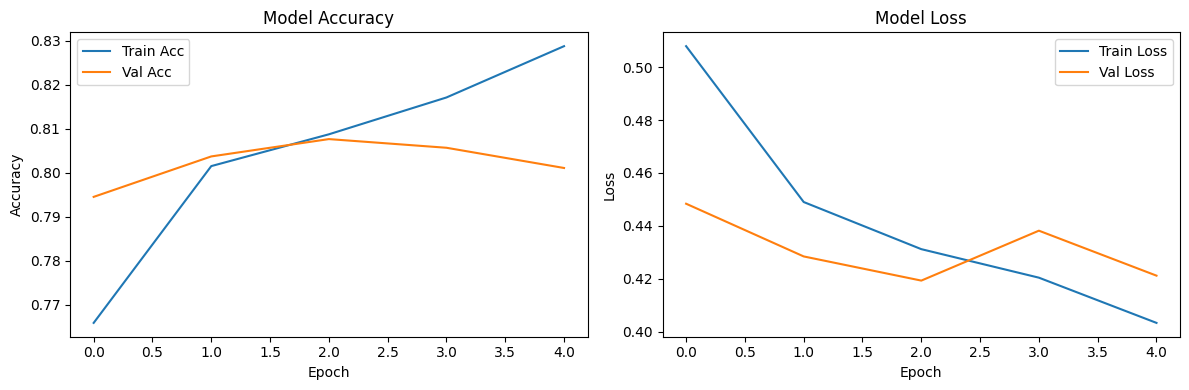

In [24]:
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

As shown above, we start losing model fidelity at ~ 3 epochs and potentially start overfitting to the train set. I could theoretically employ early stopping to clean this up.

<font face="Helvetica" size=5 color=#3c734d> **Conclusion** </font><br>

In this project, we tackled a binary classification problem: detecting whether a tweet is about a real disaster. We used a Long Short-Term Memory (LSTM) neural network trained on preprocessed tweet text, with GloVe embeddings providing rich semantic context.

<font face="Helvetica" size=4 color=#3c734d>Key Learnings & Takeaways</font><br>
* Preprocessing (text cleaning, tokenization, and sequence padding) plays a critical role in model quality.

* Pre-trained embeddings like GloVe are powerful, especially for small or noisy datasets like tweets.

* LSTM performed significantly better than traditional TF-IDF + Logistic Regression, thanks to its ability to model word order and context.

* Dropout layers and early stopping helped control overfitting on short text sequences.<br>

<font face="Helvetica" size=4 color=#3c734d> What Didn't Help</font><br>
* Increasing model size without additional regularization caused overfitting.

* Non-trainable embeddings sometimes limit performance — fine-tuning them could help.

* Location and keyword columns were sparse or inconsistent, contributing little to final model accuracy.

<font face="Helvetica" size=4 color=#3c734d> Future Improvements</font><br>
* Try Bidirectional LSTM or GRU layers for richer context.

* Incorporate attention mechanisms for more explainable models.

* Use trainable embeddings or fine-tuned BERT embeddings (e.g., via HuggingFace).

* Address class imbalance with techniques like SMOTE or class weights.